<a href="https://colab.research.google.com/github/masoudshahrian/DeepLearning-Code/blob/main/Face_Inpainting_using_AutoEncoder_CelebA_with_Measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from skimage.metrics import structural_similarity as ssim

In [2]:

# Set your image dataset paths
train_path = '/content/drive/MyDrive/Image/train'
test_path = '/content/drive/MyDrive/Image/test'


In [3]:
# Load and preprocess the dataset
def load_images(path, img_size=(64, 64)):
    images = []
    for file in glob.glob(path + "/*.jpg"):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        images.append(img)
    return np.array(images)

# Split images into upper and lower halves
def split_images(images):
    upper_half = []
    lower_half = []
    for img in images:
        h, w, _ = img.shape
        upper_half.append(img[:h//2, :])
        lower_half.append(img[h//2:, :])
    return np.array(upper_half), np.array(lower_half)

In [4]:


# Initiate autoencoder
def build_autoencoder(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)

    encoder_output = layers.Dense(256, activation='relu')(x)
    encoder = models.Model(encoder_input, encoder_output)

    decoder_input = layers.Input(shape=(256,))
    x = layers.Dense((input_shape[0]//4) * (input_shape[1]//4) * 64, activation='relu')(decoder_input)
    x = layers.Reshape((input_shape[0]//4, input_shape[1]//4, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = models.Model(decoder_input, decoder_output)

    autoencoder_input = layers.Input(shape=input_shape)
    encoded_img = encoder(autoencoder_input)
    decoded_img = decoder(encoded_img)

    autoencoder = models.Model(autoencoder_input, decoded_img)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [5]:
# Load and preprocess the training dataset
train_images = load_images(train_path)
upper_half_train, lower_half_train = split_images(train_images)

# Normalize Data
upper_half_train = upper_half_train / 255.0
lower_half_train = lower_half_train / 255.0

# Build and train the autoencoder
input_shape = upper_half_train.shape[1:]
autoencoder = build_autoencoder(input_shape)

In [17]:
len(train_images)

8000

In [22]:
# Train the model
autoencoder.fit(upper_half_train, lower_half_train, epochs=300, batch_size=32, validation_split=0.1)

# Save the model
autoencoder.save('autoencoder_model.h5')

Epoch 1/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0252 - val_loss: 0.0320
Epoch 2/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0232 - val_loss: 0.0322
Epoch 3/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0213 - val_loss: 0.0327
Epoch 4/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0197 - val_loss: 0.0341
Epoch 5/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - val_loss: 0.0339
Epoch 6/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169 - val_loss: 0.0347
Epoch 7/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0160 - val_loss: 0.0346
Epoch 8/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0151 - val_loss: 0.0346
Epoch 9/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0351
Epoch 10/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0137 - val_loss: 0.0362
Epoch 11/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0357
Epoch 12/300
225/225 ━━━━━━━━━━━━━━━━━━━━

In [23]:
# Load and preprocess the test dataset
test_images = load_images(test_path)
upper_half_test, lower_half_test = split_images(test_images)

# Normalize test data
upper_half_test = upper_half_test / 255.0

# Predict the lower half using the model
lower_half_pred = autoencoder.predict(upper_half_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [24]:
len(test_images)

2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)


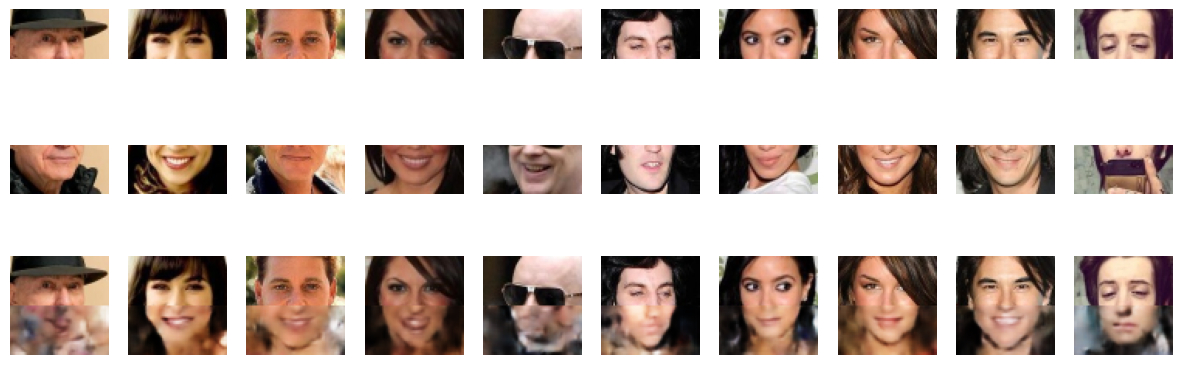

In [25]:

def display_results(model, upper_half_test, lower_half_pred):
    predictions = model.predict(upper_half_test)

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))

    for i in range(10):
        # چاپ ابعاد نیمه بالایی و پیش‌بینی
        print(f"Upper half shape: {upper_half_test[i].shape}, Prediction shape: {predictions[i].shape}")

        # نمایش نیمه بالایی
        axes[0, i].imshow(upper_half_test[i])
        axes[0, i].axis('off')

        # نمایش نیمه پایینی
        axes[1, i].imshow(lower_half_pred[i])
        axes[1, i].axis('off')

        # ترکیب نیمه بالایی و پیش‌بینی
        combined_image = np.vstack((upper_half_test[i], predictions[i]))

        # نمایش تصویر ترکیبی
        axes[2, i].imshow(combined_image)
        axes[2, i].axis('off')

    plt.show()

# فرض کنید که autoencoder، upper_half و lower_half از قبل تعریف شده‌اند
display_results(autoencoder, upper_half_test, lower_half_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)
Upper half shape: (32, 64, 3), Prediction shape: (32, 64, 3)


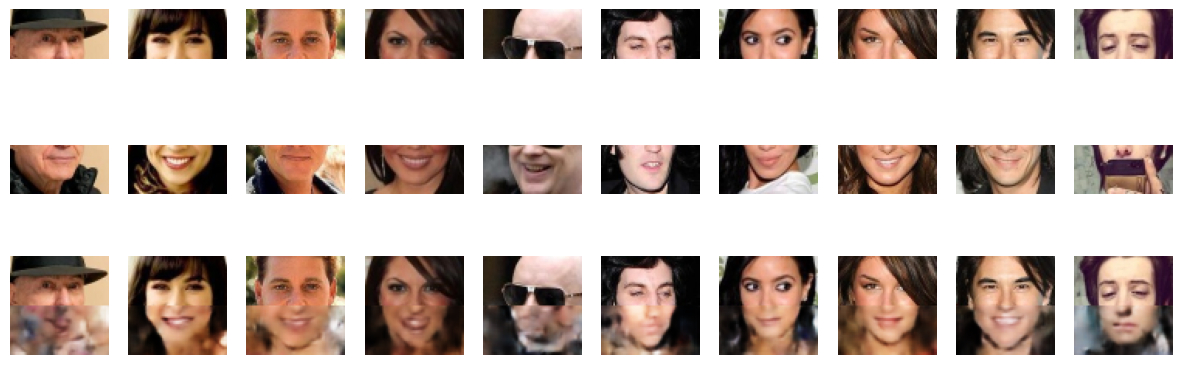

In [28]:
display_results(autoencoder, upper_half_test, lower_half_test)

In [13]:
# # Function to calculate PSNR
# def calculate_psnr(original, predicted):
#     original = original.astype(np.float32)
#     predicted = predicted.astype(np.float32)
#     mse = np.mean((original - predicted) ** 2)
#     if mse == 0:
#         return float('inf')  # Infinite PSNR if images are identical
#     max_pixel = 1.0  # Assuming images are normalized to [0, 1]
#     psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
#     return psnr

# # Function to calculate SSIM with a custom window size
# def calculate_ssim(image1, image2):
#     if image1.shape[0] < 7 or image1.shape[1] < 7:
#         return None
#     return ssim(image1, image2, multichannel=True, win_size=3)

In [26]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Function to calculate PSNR
def calculate_psnr(original, predicted):
    original = original.astype(np.float32)
    predicted = predicted.astype(np.float32)
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:
        return float('inf')  # Infinite PSNR if images are identical
    max_pixel = 1.0  # Assuming images are normalized to [0, 1]
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Function to calculate SSIM with a custom window size
def calculate_ssim(image1, image2):
    # print(f"Image1 shape: {image1.shape}, Image2 shape: {image2.shape}")
    if image1.shape[0] < 7 or image1.shape[1] < 7:
        print("Image dimensions are too small for SSIM calculation.")
        return None
    else:
        return ssim(image1, image2, multichannel=True, win_size=3, data_range=1)  # Assuming images are in range [0, 1]

# Calculate metrics
psnr_values = []
ssim_values = []

for i in range(len(lower_half_test)):
    psnr_value = calculate_psnr(lower_half_test[i], lower_half_pred[i])
    ssim_value = calculate_ssim(lower_half_test[i], lower_half_pred[i])  # Use the custom function

    psnr_values.append(psnr_value)
    if ssim_value is not None:  # Only append if SSIM was calculated
        ssim_values.append(ssim_value)

# Print average metrics
print(f"Average PSNR: {np.mean(psnr_values)}")
if ssim_values:  # Check if SSIM values were calculated
    print(f"Average SSIM: {np.mean(ssim_values)}")

Average PSNR: -41.98201858660247
Average SSIM: 0.00037317609490178643


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


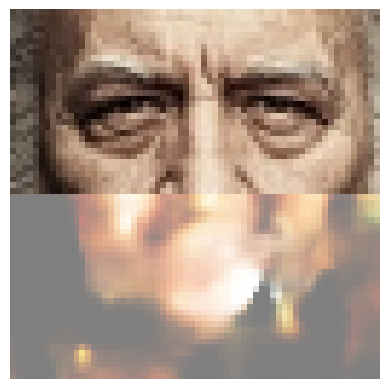

In [27]:
# Load and preprocess the new image
def load_and_preprocess_image(image_path, img_size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return img


# Split the image into upper half
def split_image(img):
    h, w, _ = img.shape
    upper_half = img[:h//2, :]
    return upper_half

# ترکیب نیمه بالا و پایین و نمایش تصویر کامل
def combine_and_display(upper_half, lower_half_pred):
    full_face = np.vstack((upper_half, lower_half_pred))
    plt.imshow(full_face)
    plt.axis('off')
    plt.show()


# تابع پیش‌بینی و نمایش صورت کامل
def predict_and_display_full_face(autoencoder, image_path):
    new_image = load_and_preprocess_image(new_image_path)
    upper_half = split_image(new_image)
    upper_half_normalized = (upper_half.astype(np.float32) - 127.5) / 127.5
    upper_half_normalized = np.expand_dims(upper_half_normalized, axis=0)

    lower_half_pred = autoencoder.predict(upper_half_normalized)[0]
    lower_half_pred = (lower_half_pred * 127.5 + 127.5).astype(np.uint8)

    # combined_image = np.vstack((upper_half, lower_half_pred))

    combine_and_display(upper_half, lower_half_pred)

# مسیر تصویر جدید
new_image_path ="/content/1 (2361).jpg"# "/path/to/new/image.jpg"
predict_and_display_full_face(autoencoder, new_image_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')